In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
warnings.filterwarnings('ignore')

In [31]:
train_data = pd.read_csv('../input/train.csv')
train_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [32]:
train_data.drop(['id', 'molecule_name'], axis=1, inplace=True)

In [33]:
print(train_data.isnull().sum())

atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
dtype: int64


No missing values. Looking for outliers now.

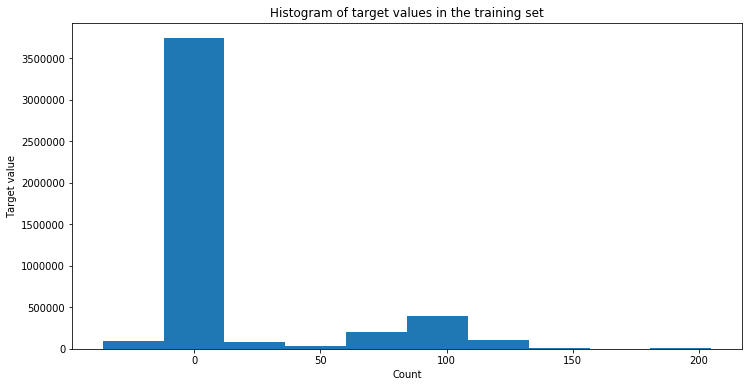

<Figure size 432x288 with 0 Axes>

In [34]:
plt.figure(figsize = (12, 6))
plt.hist(train_data['scalar_coupling_constant'])
plt.title('Histogram of target values in the training set')
plt.xlabel('Count')
plt.ylabel('Target value')
plt.show()
plt.clf()

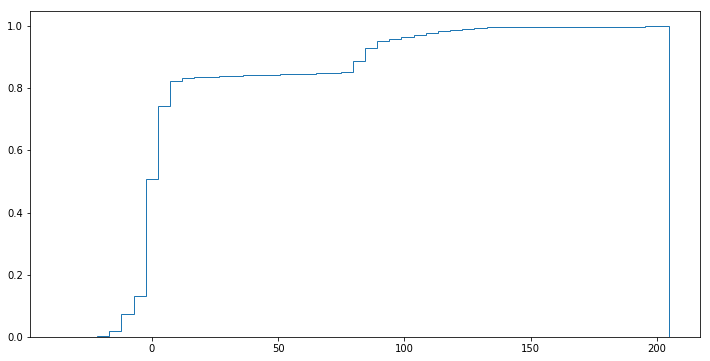

In [35]:
x = train_data['scalar_coupling_constant']

fig, ax = plt.subplots(figsize=(12, 6))
n_bins = 50

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Empirical')

Any distance more than 160 can be called as outlier. Remove entries with those entries

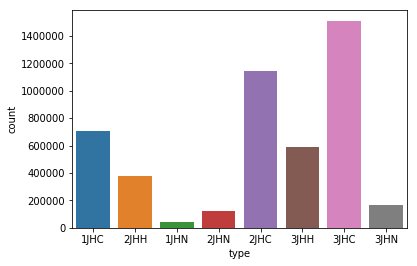

In [36]:
sbn.countplot(x='type', data=train_data)

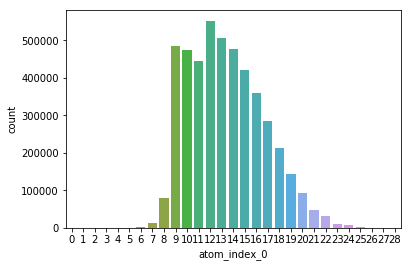

In [37]:
sbn.countplot(x='atom_index_0', data=train_data)

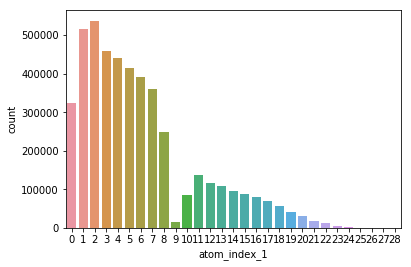

In [38]:
sbn.countplot(x='atom_index_1', data=train_data)

In [39]:
indices = [index for index, row in train_data.iterrows() 
           if row['scalar_coupling_constant']>160]
print("Before deletion: ", train_data.shape)
train_data.drop(train_data.index[indices], axis=0, inplace=True)
print("After deletion: ", train_data.shape)

Before deletion:  (4658147, 4)
After deletion:  (4648878, 4)


In [40]:
encoded_data = pd.get_dummies(train_data['type'])
train_data = train_data.join(encoded_data)
train_data.drop(['type', '3JHN'], axis=1, inplace=True)
train_data.head()

,atom_index_0,atom_index_1,scalar_coupling_constant,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH
0,1,0,84.8076,1,0,0,0,0,0,0
1,1,2,-11.2570,0,0,0,1,0,0,0
2,1,3,-11.2548,0,0,0,1,0,0,0
3,1,4,-11.2543,0,0,0,1,0,0,0
4,2,0,84.8074,1,0,0,0,0,0,0


In [41]:
target = np.asarray(train_data['scalar_coupling_constant'].tolist())
train_data.drop(['scalar_coupling_constant'], axis=1, inplace=True)
features = train_data.iloc[:,:].values

In [42]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [49]:
min_max_scaler = MinMaxScaler(feature_range=(0,10))
target = target.reshape(-1,1)
target = min_max_scaler.fit_transform(target)
target

array([[6.1717958 ],
       [1.27293014],
       [1.27304233],
       ...,
       [1.90682351],
       [2.08982812],
       [7.86109428]])

In [55]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.15, random_state=42)

model = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1)
model.fit(train_features, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   50.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=1, warm_start=False)

In [56]:
test_predictions = model.predict(test_features)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


In [58]:
error = mean_squared_error(test_target, test_predictions)
print(error)

0.09190611090512837


In [59]:
test_data = pd.read_csv('../input/test.csv')
encoded_data = pd.get_dummies(test_data['type'])
test_data = test_data.join(encoded_data)
test_data.drop(['id', 'type', 'molecule_name', '3JHN'], axis=1, inplace=True)

test_features = test_data.iloc[:,:].values
test_features = scaler.transform(test_features)

In [60]:
predictions = model.predict(test_features)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished


In [62]:
predictions = min_max_scaler.inverse_transform(predictions.reshape(-1,1))
predictions

array([[1.89090527],
       [7.20876382],
       [2.16316749],
       ...,
       [2.04456077],
       [1.85675069],
       [7.25936505]])

In [63]:
submission = pd.read_csv('../input/sample_submission.csv')
submission.head()

,id,scalar_coupling_constant
0,4658147,0
1,4658148,0
2,4658149,0
3,4658150,0
4,4658151,0


In [ ]:
submission['scalar_coupling_constant'] = predictions
submission.to_csv('submission.csv', index=False)